<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/094.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [8]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df_093.csv')

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df_093.csv')

In [9]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [10]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [11]:
train_df_060 = pd.read_csv(path+'train_all_df_060.csv')
train_df_060.iloc[1119:, :]

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
1119,33573.984771,27691.372510,29531.772147,82,76957.791208,49590.840696,47884.127681,26206.461981,30.220520,-93.742096,1966.146709,-5882.612261,1840.399637,0.062204,-0.175213,0.066461,8,0,44716.650823,45777.122845
1120,NaN,NaN,NaN,21,72874.379509,188701.992178,245700.971833,521373.221691,27.567140,-99.505230,NaN,NaN,NaN,NaN,NaN,NaN,15,1,251942.311116,246021.200746
1121,15769.087207,17223.969527,14451.509512,147,25203.960001,50606.672273,43583.464216,68569.211500,35.811390,-83.967210,630.093954,1454.882320,-2772.460015,0.041621,0.092262,-0.160965,8,0,40922.371684,42127.751931
1122,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,61169.098865,57020.151719
1123,30643.194107,34202.870598,30363.253058,21,305757.037478,218576.699790,295789.568177,192767.142277,32.017180,-109.894337,-4088.201978,3559.676491,-3839.617540,-0.117709,0.116165,-0.112260,15,0,268182.786286,271530.824987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,24101.026379,19191.516543,26927.123407,20,77141.021213,48631.025258,47793.361605,26264.074210,31.395000,-92.716700,8850.589715,-4909.509837,7735.606864,0.580350,-0.203705,0.403074,15,0,46740.289062,49221.615755
4651,NaN,NaN,NaN,92,82220.042676,64715.871307,230047.214696,560693.884154,34.063540,-117.529290,NaN,NaN,NaN,NaN,NaN,NaN,8,1,170354.516977,169634.209493
4652,24256.968166,25344.483061,25052.338495,80,28607.351065,19289.908089,31161.166202,41108.719593,44.889130,-89.624800,2857.424868,1087.514895,-292.144565,0.133527,0.044833,-0.011527,8,0,31492.170648,31716.323514
4653,25345.077827,15031.292599,15796.850949,98,88531.792834,72951.833989,58934.618361,53983.891144,37.786820,-97.530970,8121.896740,-10313.785228,765.558350,0.471568,-0.406934,0.050931,8,0,66290.436080,65663.219471


In [12]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,5.798506e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,1.017332e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,1.330859e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,2.654853e+05


In [13]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,test_preds
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.503991e+04,4.506929e+04
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.981288e+05,2.975597e+05
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.142984e+04,4.115429e+04
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.926387e+04,2.836366e+04
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.776136e+04,4.837460e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [14]:
before_train = pd.read_csv(path+'train.csv', index_col=0)
before_test = pd.read_csv(path+'test.csv', index_col=0)
before_test

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons
4655,ROGER AOTSCHEGAROW,38.033040,-97.973170,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,211112,NaN,"Natural Gas and Natural Gas Liquids Suppliers,...",NaN,NaN,NaN,NaN,88951.390376,65803.021457,2.899329e+04,32965.487915
4656,EPNG STATION 6543 LORDSBURG,32.316030,-108.606800,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,3.119260e+05,268668.069110
4657,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.251500,-78.742440,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,327213,NaN,Minerals,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387
4658,WALDORF CORP (DBA ROCKTENN),44.959660,-93.193410,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,322130,NaN,Pulp and Paper,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986
4659,SOLAR TURBINES INC KEARNY MESA,32.818720,-117.125800,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,333611,NaN,Other,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,BEULAH SANITARY LANDFILL,38.651945,-75.914445,ROUTE 331 & ROUTE 16- BEULAH ROAD,HURLOCK,MD,21643,DORCHESTER,24019.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,110523.066755,98954.793233,3.467008e+06,147802.356027
7159,SONORA GAS PLANT,31.361795,-101.776403,NaN,RANKIN,TX,79778,UPTON,48461.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7160,ASH GROVE CEMENT CO,41.005565,-96.154917,16215 HWY 50,LOUISVILLE,NE,680372881,CASS,31025.0,327310,NaN,Minerals,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307153
7161,SHOW ME ETHANOL LLC,39.364417,-93.449361,26530 E HWY 24,CARROLLTON,MO,64633,CARROLL,29033.0,325193,NaN,"Other,Waste",124460.895022,140816.449347,93118.705227,130326.946431,71773.803649,936031.894142,3.369613e+05,156640.371706


In [15]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


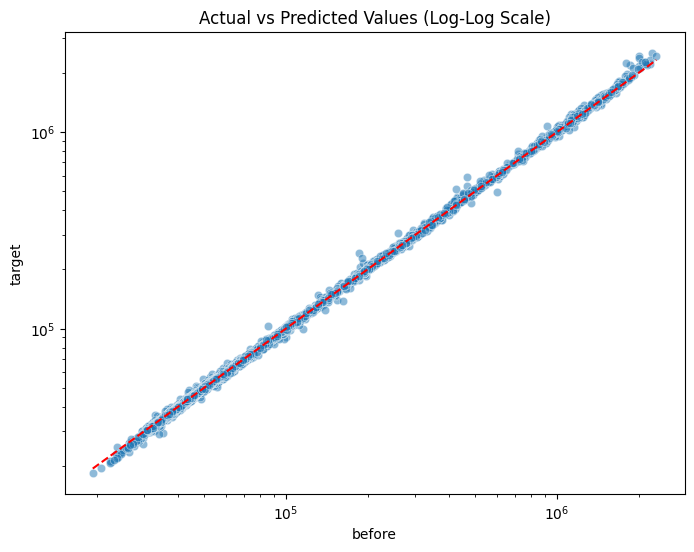

In [16]:

x=train_df["oof_predictions"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

In [17]:

# show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
#           train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
#           "train_G13-train_G14")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
#           np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_log_G13-train_log_G14")
# show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
#           np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
#           "train_log_G12-train_log_G13")


In [18]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [19]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [20]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [21]:
len(train_df), len(train_all_df), len(test_df)

(6045, 8553, 2508)

In [22]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[len(train_df):]

In [23]:
train_all_df["diff"]

,diff
0,-0.001628
1,-0.008791
2,0.019985
3,-0.002956
4,-0.018009
...,...
2503,0.005919
2504,0.015370
2505,0.017621
2506,-0.008465


In [24]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [25]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [26]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [27]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")
    print()
    return oof_predictions, final_test_predictions, final_train_predictions

In [28]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,0.005662
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.015313
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.011971
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.008572


In [29]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [30]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,-0.008465


In [31]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,0.005662
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.015313
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.011971
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.008572


In [32]:
train_df_GHG14 = pd.Series(train_df_GHG14)

In [33]:
len(train_df_GHG14)

6045

In [34]:
import time
epock = 10
for i in range(epock):
    st = time.time()
    train = train_df.iloc[:, :-1].values
    train_all = train_all_df.iloc[:, :-1].values
    train_all_target = train_all_df.iloc[:, -1].values
    oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)
    train_all_df["oof_predictions"] = np.expm1(np.log1p(train_all_df["oof_predictions"])+oof_predictions)
    train_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    test_df["oof_predictions"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
    # train_all_df のインデックスをリセット
    train_all_df = train_all_df.reset_index(drop=True)

# train_df_GHG14 のインデックスをリセット
    train_df_GHG14 = train_df_GHG14.reset_index(drop=True)
    train_all_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_all_df['oof_predictions'])
    train_all_df.fillna(0, inplace=True)
    train_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_df['oof_predictions'])
    print(f"{i}番目の学習が終わりました。\n")
    print(f"推定時間は{int(((epock-1-i)*(time.time()-st))/60)}\n")

ストリーミング出力は最後の 5000 行に切り捨てられました。
Fold 18 RMSLE for ('model1', 'model2') = 0.008595655158573183
Fold 18 RMSLE for ('model1', 'model3') = 0.008725242703861111
Fold 18 RMSLE for ('model1', 'model4') = 0.008419945174002194
Fold 18 RMSLE for ('model2', 'model3') = 0.008941225860679466
Fold 18 RMSLE for ('model2', 'model4') = 0.00863727321290249
Fold 18 RMSLE for ('model3', 'model4') = 0.008743194013370884
Fold 18 RMSLE for ('model1', 'model2', 'model3') = 0.008736295363902885
Fold 18 RMSLE for ('model1', 'model2', 'model4') = 0.008539907483029572
Fold 18 RMSLE for ('model1', 'model3', 'model4') = 0.00861757273655781
Fold 18 RMSLE for ('model2', 'model3', 'model4') = 0.00875820743520198
Fold 18 RMSLE for all models ensemble = 0.008655900097168536
Fold 18 best combination: model1 with RMSLE = 0.008414111611737551
---------------

Starting Fold 19
Fold 19 RMSLE for model1 = 0.01123143023702696
Fold 19 RMSLE for model2 = 0.01187582951734262
Fold 19 RMSLE for model3 = 0.011456627249152652
Fold 19

In [35]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.100001e+04,-0.000374
1,0.000000,0.000000,0.000000,0.000000,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,1,6.027524e+04,-0.000989
2,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,0.000000e+00,0.000000,39.299820,-80.857170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,1,1.013700e+05,0.004874
3,0.000000,0.000000,0.000000,0.000000,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,1,5.193587e+04,0.000851
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.919586e+04,-0.004063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8548,0.000000,0.000000,0.000000,0.000000,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,5.293676e+05,0.000000
8549,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,0.000000e+00,0.000000,31.361795,-101.776403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,1,1.019445e+05,0.000000
8550,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.386703e+05,0.000000
8551,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.627613e+05,0.000000


In [36]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.090082e+04,0.002048
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.632440e+04,-0.096624
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.126121e+05,-0.100296
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.663580e+04,-0.085779
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.926228e+04,-0.005412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,6.083564e+05,-0.047990
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.142346e+05,-0.115899
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.323684e+05,0.005406
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.656624e+05,-0.000667


In [37]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')


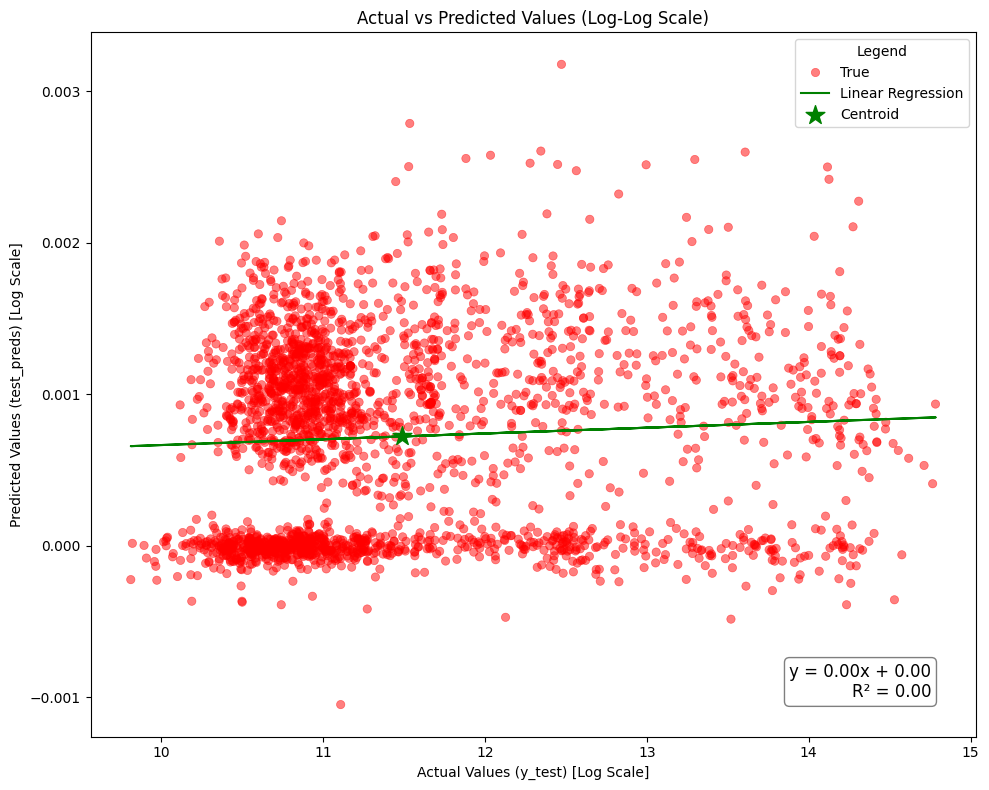

重心 (Centroid) の座標: (11.49, 0.00)


In [38]:
from scipy import stats
# 対数変換
log_target = np.log1p(test_df["oof_predictions"])
log_oof_predictions = test_preds

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [39]:
train_df_GHG14

,GHG_Direct_Emissions_14_in_metric_tons.1
0,4.098466e+04
1,6.021565e+04
2,1.018654e+05
3,5.198007e+04
4,4.899637e+04
...,...
6040,5.798506e+05
6041,1.017332e+05
6042,1.330859e+05
6043,2.654853e+05


In [40]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.864828e+04,0.000652
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,3.277151e+05,-0.001911
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.072421e+04,-0.006673
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.732870e+04,-0.031244
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.886299e+04,0.012758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.567251e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.165673e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.407857e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.607554e+05,-0.008465


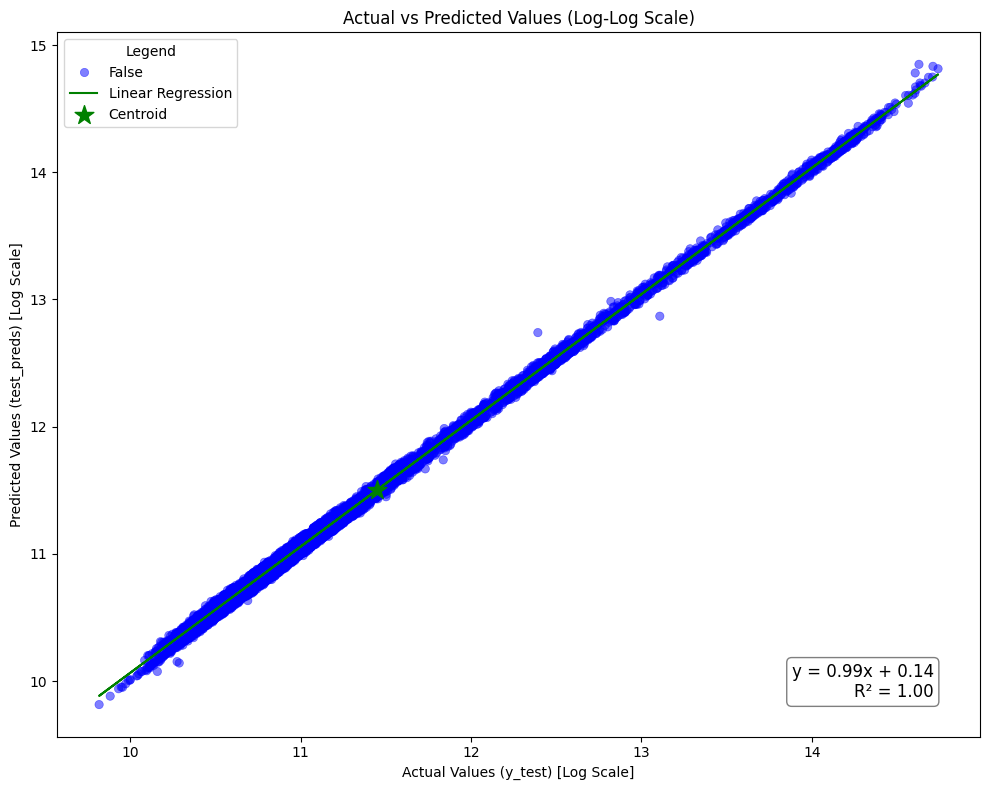

重心 (Centroid) の座標: (11.45, 11.50)


In [41]:

# 対数変換
log_target = np.log1p(train_df_GHG14)
log_oof_predictions = np.log1p(train_df["oof_predictions"])

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [42]:
print(np.expm1(10.2))
print(np.log1p(26902.18607429754))
np.expm1(np.log1p(26902.18607429754)*100/102)

26902.18607429754
10.2


22025.465794806678

In [43]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,249574.303827
1,4656,249574.303827
2,4657,249574.303827
3,4658,249574.303827
4,4659,249574.303827
...,...,...
2503,7158,249574.303827
2504,7159,249574.303827
2505,7160,249574.303827
2506,7161,249574.303827


各ビンの y のジオメトリック平均: 224708.98604667318


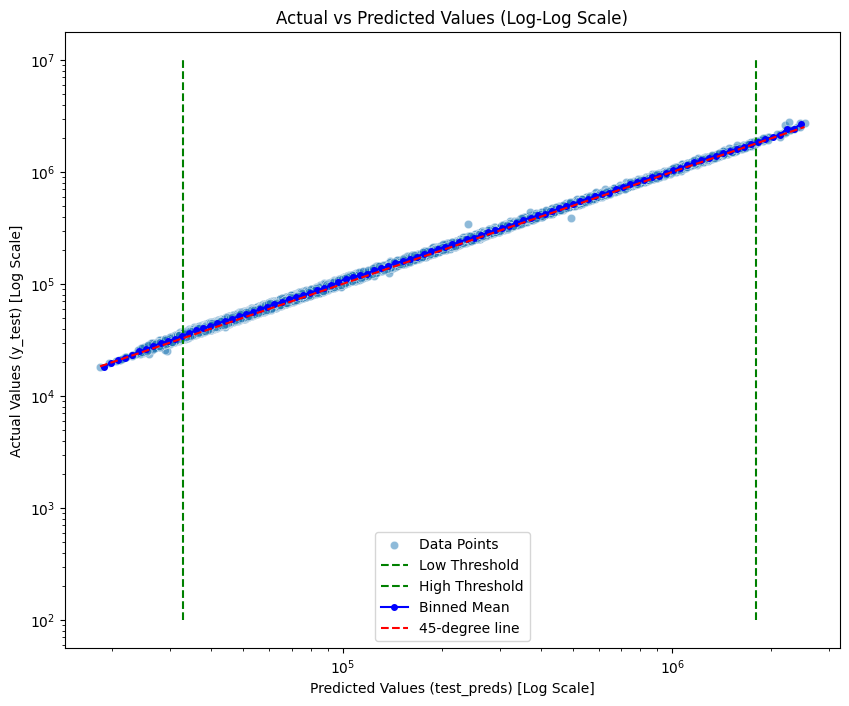

In [44]:

def calculate_binned_average(x, y, num_bins=50):
    """
    x を num_bins 個のビンに分け、それぞれのビン内の y の平均を計算します。

    Parameters:
    - x: 予測値の配列
    - y: 実測値の配列
    - num_bins: ビンの数

    Returns:
    - bins: ビンの境界
    - bin_centers: 各ビンの中心値
    - y_means: 各ビン内の y の平均値
    """
    # 対数スケールのビンを作成
    log_min = np.log10(x.min())
    log_max = np.log10(x.max())
    bins = np.logspace(log_min, log_max, num=num_bins)

    # ビンのインデックスを取得
    bin_indices = np.digitize(x, bins)

    # 各ビン内の y の平均を計算
    y_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            y_mean = y[mask].mean()
            y_means.append(y_mean)
            bin_center = (bins[i-1] + bins[i]) / 2
            bin_centers.append(bin_center)

    return bins, np.array(bin_centers), np.array(y_means)


x = train_df_GHG14
y = train_df["oof_predictions"]
# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')


# 基準点の垂直線のプロット
plt.plot([np.expm1(10.4), np.expm1(10.4)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.4), np.expm1(14.4)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [45]:
print(np.expm1(np.log1p(10)))

10.000000000000002


In [46]:
def after_act(preds):
    r = preds.copy()
    r_min = r.min()
    max_w = 10.4-np.log1p(r_min)
    for i in range(len(r)):
        if r[i] < np.expm1(10.4):
            # print(r[i]-np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w))
            r[i] = np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w)
    return r

after_test_preds = after_act(test_df["oof_predictions"])
after_train_preds = after_act(train_df["oof_predictions"])

各ビンの y のジオメトリック平均: 191001.20420287308


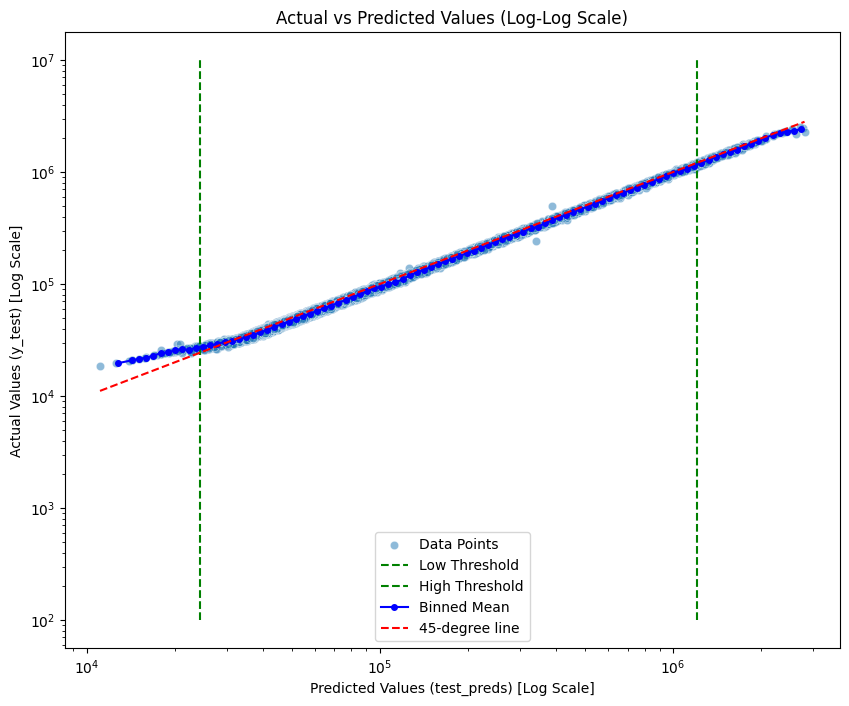

In [47]:
x = after_train_preds
y = train_df_GHG14

# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 45度線のプロット
# plt.plot([train_target.min(), train_target.max()], [train_target.min(), train_target.max()], 'r--', label='45-degree line')

# 基準点の垂直線のプロット
plt.plot([np.expm1(10.1), np.expm1(10.1)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.0), np.expm1(14.0)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [57]:
submit [ 1 ]  =  after_test_preds
submit.to_csv('SMBC_94.csv', index = False)
submit

,0,1
0,4655,"48,648"
1,4656,"327,715"
2,4657,"40,724"
3,4658,"23,376"
4,4659,"48,863"
...,...,...
2503,7158,"556,725"
2504,7159,"116,567"
2505,7160,"140,786"
2506,7161,"260,755"


In [49]:
np.expm1(14)

1202603.2841647768

In [50]:
pd.set_option('display.float_format', '{:,.0f}'.format)
threshold_input = 14
threshold = np.expm1(threshold_input)/1.05  # ≈ 1.718

# フィルタリング条件を定義
condition = (submit.iloc[:, 1] > threshold) & (submit.iloc[:, 0] > 1)

# 条件に合致する行を抽出
filtered_submit = submit[condition]
filtered_submit

,0,1
16,4671,"1,225,496"
43,4698,"1,183,839"
73,4728,"1,153,485"
110,4765,"1,427,230"
114,4769,"1,334,294"
...,...,...
2423,7078,"1,299,507"
2466,7121,"1,649,609"
2490,7145,"1,462,361"
2500,7155,"1,150,880"


In [51]:

# # show_plot(np.exp(oof_predictions), np.exp(target))
# show_plot(oof_predictions, target, "oof_predictions, target")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
# show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(after_test_preds),
#           "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")
# show_plot(np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]), np.log(after_test_preds),
#           "train_df[GHG_Direct_Emissions_14_in_metric_tons], test_preds")
# show_plot(train_df.iloc[:, -1], after_train_preds, "train_df.iloc[:, -1], train_preds")

In [52]:
# show_plot(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"], test_preds, "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [53]:
import time
print(time.ctime())

Mon Dec  2 07:10:15 2024


In [54]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"31,567","26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"40,901",0
1,NaN,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"66,324",-0
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"112,612",-0
3,NaN,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"56,636",-0
4,"29,554","28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"49,262",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"608,356",-0
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"114,235",-0
6042,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"132,368",0
6043,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"265,662",-0


In [55]:
def culc(x, y):
    return  np.sqrt(mean_squared_log_error(x, y))

culc(train_df_GHG14, train_df["oof_predictions"])

0.06932625368191836

In [56]:
train_df


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"31,567","26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"40,901",0
1,NaN,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"66,324",-0
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"112,612",-0
3,NaN,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"56,636",-0
4,"29,554","28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"49,262",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"608,356",-0
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"114,235",-0
6042,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"132,368",0
6043,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"265,662",-0
